# Проект по Python for Data Analysis

Датасет состоит из данных сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('real_estate_data.csv', encoding='utf-8', sep='\t')

## Этап 1. Предварительная обработка

### Общий обзор данных

In [7]:
pd.set_option('display.max_columns',50)
df.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [9]:
#Вывод количества пропущенных значений в каждом столбце
null_value_in_column = df.isnull().sum()
for i, (column, null_count) in enumerate(null_value_in_column.sort_values(ascending=False).items(), start=1):
    if null_count > 0:
        percent = round(null_count * 100 / len(df), 1)
        print(f"{i}. {column}: пропусков {null_count} ({percent}%)")

1. is_apartment: пропусков 20924 (88.3%)
2. parks_nearest: пропусков 15620 (65.9%)
3. ponds_nearest: пропусков 14589 (61.6%)
4. balcony: пропусков 11519 (48.6%)
5. ceiling_height: пропусков 9195 (38.8%)
6. airports_nearest: пропусков 5542 (23.4%)
7. cityCenters_nearest: пропусков 5519 (23.3%)
8. ponds_around3000: пропусков 5518 (23.3%)
9. parks_around3000: пропусков 5518 (23.3%)
10. days_exposition: пропусков 3181 (13.4%)
11. kitchen_area: пропусков 2278 (9.6%)
12. living_area: пропусков 1903 (8.0%)
13. floors_total: пропусков 86 (0.4%)
14. locality_name: пропусков 49 (0.2%)


In [10]:
#проверка на дубликаты
print(f'Количество строк дубликатов: {df.duplicated().sum()}') 

Количество строк дубликатов: 0


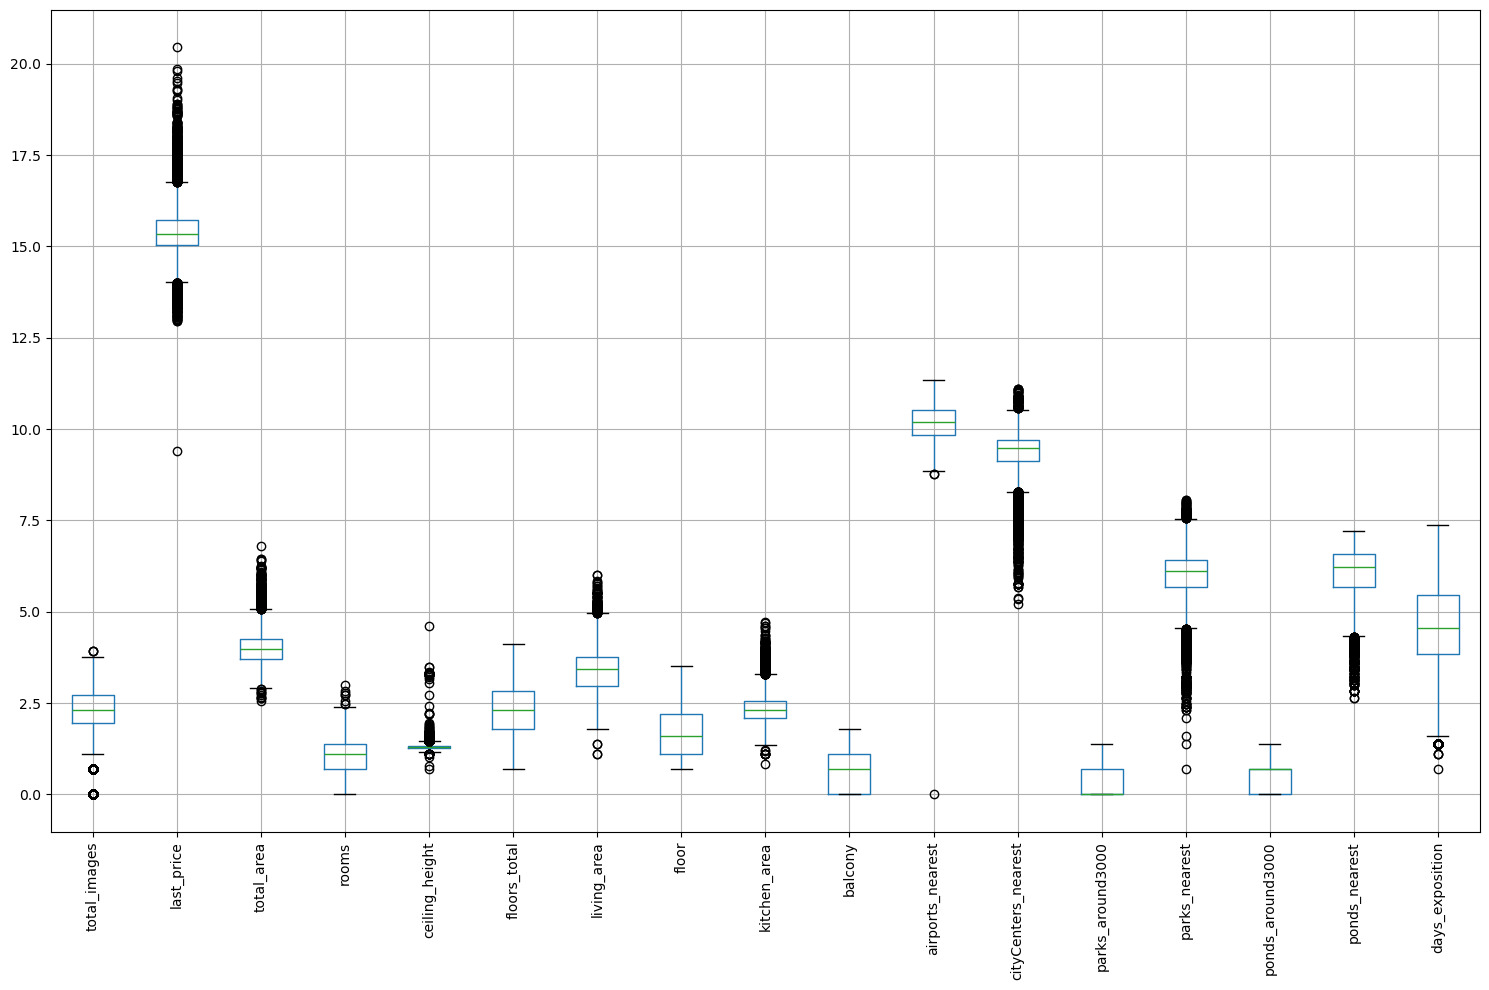

In [11]:
#C помощью boxplot проверим числовые данные на выбросы
num_df = df.select_dtypes(include=['number'])
log_df = num_df.apply(lambda col: np.log(col + 1) if col.min() >= 0 else col)

plt.figure(figsize=(15, 10))
log_df.boxplot()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [12]:
#Функция для удаления выбросов, которые оказались за пределами трех межквартильных отклонений
def remove_outliers(column_name):
    global df
    # Вычисление IQR
    qi = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - qi

    # Границы для усов
    lower_bound = qi - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Фильтрация данных
    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    # Построение боксплота для обновленных данных
    plt.boxplot(df[column_name])
    plt.show()

In [13]:
#Сохраним размер df для сравнения после обработки
len_df_start = len(df)

### Детальный обзор каждого параметра

При анализе параметров выполнены следующие шаги:

    1. Обзор уникальных значений для визуальной оценки корректности данных. 
    2. Анализ пропусков и замена при возможности.
    3. Удаление выбросов, методом трех межквартильных отклонений или 99% персентилем.
    4. Форматирование значений или замена типа данных при необходимости.

Результаты обработки по каждому параметру:
1. total_images - удалены выбросы методом трех межквартильных отклонений.
2. last_price - удалены строки с редкими значениями (99% персентиль), значения округлены до целого числа.
3. total_area - удалены выбросы методом трех межквартильных отклонений.
4. first_day_exposition - удалена временная метка, осталась только дата.
5. rooms - значение 0 заменено на 1, удалены выбросы методом трех межквартильных отклонений.
6. ceiling_height - пропущенные значения заменены на среднее значение, удалены выбросы методом трех межквартильных отклонений.
7. floors_total - приведен к типу int, удалены все строки с пропусками, удалены строки с редкими значениями (99% персентиль).
8. living_area - пропуски заменены на среднее значение этого параметра с той же общей площадью, удалены выбросы методом трех межквартильных отклонений, округение до 2-знаков после запятой.
9. floor - удалены выбросы методом трех межквартильных отклонений.
10. is_apartment - пропуски заменены на значениe False (т.е. квартира).
11. studio - без изменений.
12. open_plan - без изменений.
13. balcony - заменены пропущенные значения на 0 (нет балкона), приведен к типу int, удалены выбросы методом трех межквартильных отклонений.
14. kitchen_area - пропуски заменены на среднюю долю кухни от нежилой зоны по всем строкам, удалены выбросы методом трех межквартильных отклонений.
15. airports_nearest - без измнений, в том числе оставлены пропуски.
16. cityCenters_nearest - без измнений, в том числе оставлены пропуски.
17. days_exposition -  заменены пропущенные значения на 0, приведен к типу int, удалены выбросы методом трех межквартильных отклонений.
18. locality_name - заменены дубликаты названий, пропуски оставлены.
19. parks_nearest - сделаны замены пропусков на 3100 в тех строках, где известно, что в радиусе 3 км нет парка, остались пропуски.
20. ponds_nearest - сделаны замены пропусков на 3100 в тех строках, где известно, что в радиусе 3 км нет водоема, остались пропуски.
21. parks_around3000 - без изменений, остались пропуски.
22. ponds_around3000 - без изменений, остались пропуски.

Обоснование выбора способа удаления выбросов:
Для параметров last_price, floors_total выбран 99% персентиль, чтобы удалить экстремальные редкие значения, но в целом, длинный хвост для этих значений уместен.
Для других параметров был выбран методо трех межквартильных отклонений, так как необходимо убрать некорректные как миинимальные значения и так и максимальльные значения (например, потолки 1 метр или площадь кухни 600 м. кв).

#### total_images

In [18]:
# просмотр уникальных значений
df['total_images'].value_counts()

total_images
10    1798
9     1725
20    1694
8     1585
7     1521
6     1482
11    1362
5     1301
12    1225
0     1059
13    1015
4      986
14     986
15     948
1      872
3      769
16     761
17     650
18     642
2      640
19     603
23      16
21      12
24       8
22       8
26       5
32       4
28       4
50       3
29       3
27       2
30       2
35       2
31       2
42       1
25       1
39       1
37       1
Name: count, dtype: int64

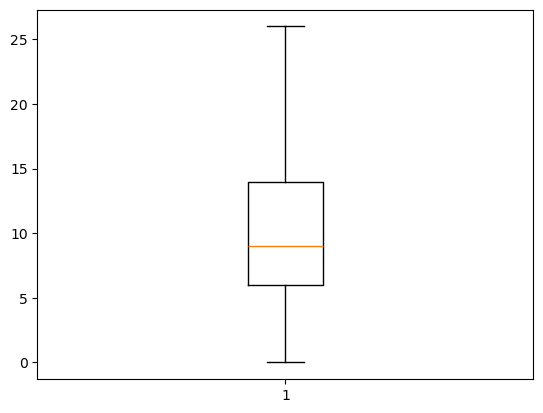

In [19]:
#Уберем выбросы
remove_outliers('total_images')

#### last_price

In [21]:
#Просмотрим уникальные значения
df['last_price'].unique()

array([13000000.,  3350000.,  5196000., ...,  6151120., 21400000.,
       11475000.])

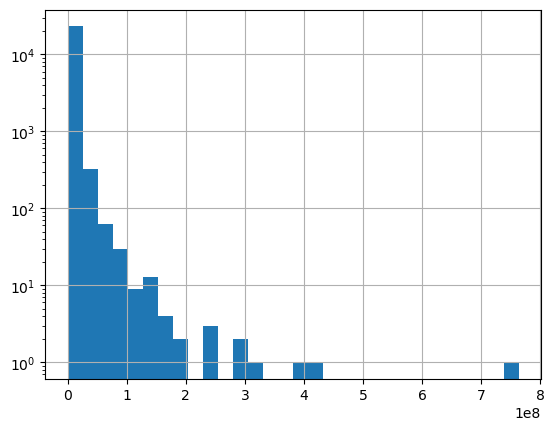

In [22]:
#Поиск аномалий
df['last_price'].hist(bins=30, log=True)
plt.show()

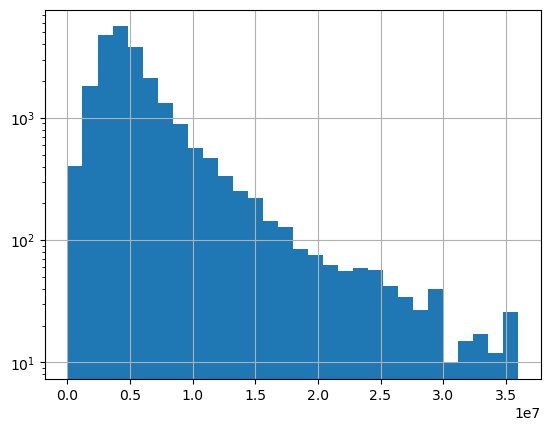

In [23]:
#Уберем 1% аномальных значений. Воспользуемся 99% персентилем
threshold = df['last_price'].quantile(0.99)
df = df[df.last_price <= threshold]

# Визуализируем
df['last_price'].hist(bins=30, log=True)
plt.show()

In [24]:
# Округление до целого
df['last_price'] = df['last_price'].round(0)

#### total_area

In [26]:
#Уникальные значения
df['total_area'].unique()

array([108.  ,  40.4 ,  56.  , ...,  66.86, 133.81,  76.75])

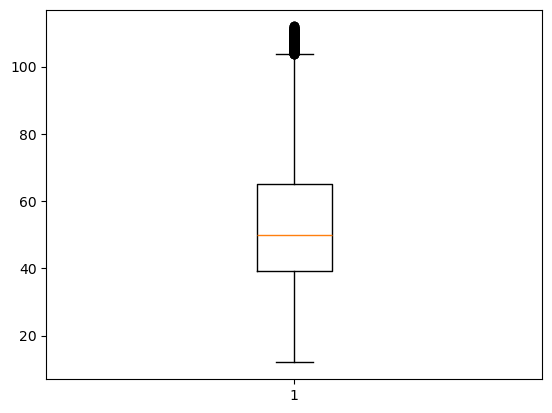

In [27]:
#Удаляем выбросы
remove_outliers('total_area')

#### first_day_exposition

In [29]:
#Уникальные значения
df['first_day_exposition'].unique()

array(['2019-03-07T00:00:00', '2018-12-04T00:00:00',
       '2015-08-20T00:00:00', ..., '2014-12-29T00:00:00',
       '2016-09-12T00:00:00', '2015-07-19T00:00:00'], dtype=object)

In [30]:
#Оставим только дату, так как все временные метки одинаковы
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition']).dt.normalize()

#### rooms

In [32]:
# Уникальные значения
df['rooms'].value_counts()

rooms
1    8038
2    7886
3    5384
4     745
0     196
5      67
6       9
7       1
Name: count, dtype: int64

Есть строки с числом комнат 0, что не может быть. Проанализируем и сделаем замену:

In [34]:
#Сгруппируем кол-во комнат по размеру жилой зоны
df.groupby('rooms')['living_area'].mean()

rooms
0    18.865246
1    17.878412
2    31.618668
3    45.653206
4    55.499019
5    64.620339
6    75.562500
7          NaN
Name: living_area, dtype: float64

In [35]:
#Заменим число комнат с 0 на 1, так как они имеют схожее значение по параметру размер жилой площади
df['rooms'] = df['rooms'].replace(0, 1)

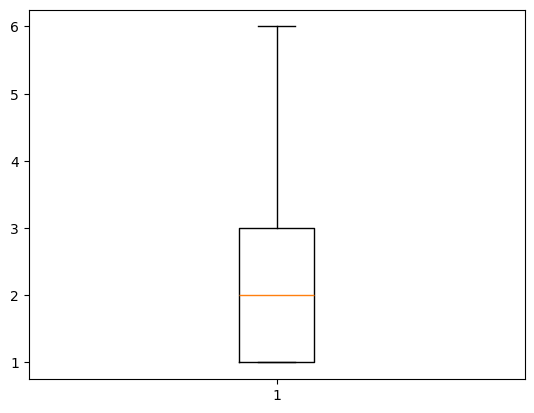

In [36]:
#Удалим выбросы
remove_outliers('rooms')

#### ceiling_height

In [38]:
#Уникальные значения
df['ceiling_height'].value_counts()

ceiling_height
2.50    3495
2.60    1635
2.70    1530
2.55     974
2.80     933
        ... 
4.30       1
3.39       1
5.00       1
2.20       1
3.59       1
Name: count, Length: 165, dtype: int64

In [39]:
# В уникальных значениях высоты потолока есть двузначные значения 24.00, вероятно, здесь ошибка в указании десятой части. Сделаем замену
df['ceiling_height'] = df['ceiling_height'].apply(lambda x: x / 10 if x > 10 else x)

In [40]:
# Количество пустых значений
print(f'Количество пустых значений {df['ceiling_height'].isnull().sum()}')

Количество пустых значений 8748


In [41]:
print(f'Cреднее = {df['ceiling_height'].mean()}')
print(f'Медиана = {df['ceiling_height'].median()}')

Cреднее = 2.700088384768358
Медиана = 2.63


In [42]:
#Заменим пустые значения средним по всей выборке
df['ceiling_height'] = df['ceiling_height'].fillna(round(df['ceiling_height'].mean(),2))

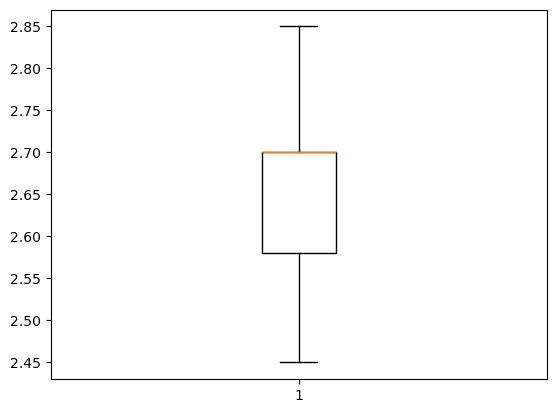

In [43]:
#Удалим выбросы
remove_outliers('ceiling_height')

#### floors_total

In [45]:
# просмотр уникальных значений
df['floors_total'].value_counts()

floors_total
5.0     4771
9.0     3634
12.0    1279
16.0    1222
10.0    1088
25.0    1025
17.0     761
4.0      684
14.0     528
3.0      471
18.0     471
24.0     444
6.0      419
23.0     328
7.0      326
15.0     307
19.0     306
2.0      292
22.0     274
8.0      257
20.0     235
13.0     205
27.0     163
11.0     162
21.0     151
26.0     120
35.0      24
28.0      21
1.0       18
36.0       3
34.0       1
29.0       1
33.0       1
52.0       1
Name: count, dtype: int64

In [46]:
# Количество пустых значений
print(f'Количество пустых значений {df['floors_total'].isnull().sum()}')

Количество пустых значений 80


In [47]:
#Удалим строки с пустыми значенями, так как их меньше 0,5%
df = df.dropna(subset=['floors_total'])

In [48]:
#Приведем значения к типу int
df['floors_total'] = df.floors_total.astype(int)

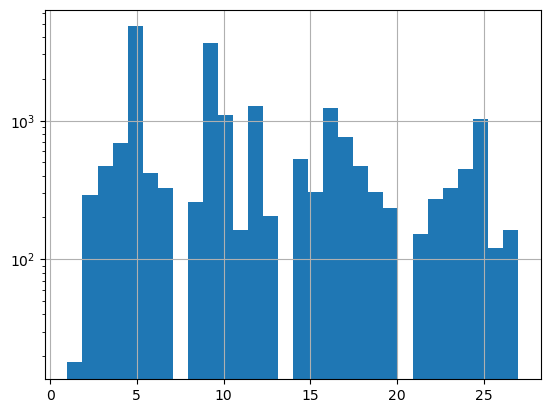

In [49]:
#Уберем 1% аномальных значений. Воспользуемся 99% персентилем
threshold = df['floors_total'].quantile(0.99)
df = df[df.floors_total <= threshold]

# Визуализируем
df['floors_total'].hist(bins=30, log=True)
plt.show()

#### living_area 

In [51]:
# Просмотр уникальных значений
df['living_area'].unique()

array([51.  , 18.6 , 34.3 , ..., 31.65, 70.6 , 42.55])

In [52]:
# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df['living_area'].isna().sum()}')

Количество пропущенных значений: 1595


In [53]:
# Замена пропусков в living_area средним значением для тех же total_area
df['living_area'] = df.groupby(df['living_area'].round())['living_area'].transform(lambda group: group.fillna(group.mean()))

In [54]:
df.groupby(df['total_area'].round())['living_area'].mean()

total_area
12.0     10.000000
13.0     10.000000
14.0     11.000000
15.0           NaN
16.0     11.500000
           ...    
108.0    62.609375
109.0    59.154545
110.0    67.022727
111.0    66.950000
112.0    64.906000
Name: living_area, Length: 101, dtype: float64

In [55]:
#Оставшийся пропуск заменим на число 11
df.loc[df['total_area'].round()== 15.00, 'living_area'] = 11.0

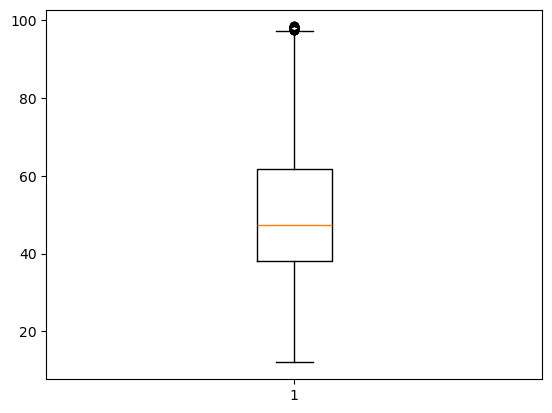

In [56]:
#Удалим выбросы
remove_outliers('total_area')

In [57]:
#округлим до двух знаков после запятой
df['living_area'] = df['living_area'].round(2)

#### floor

In [59]:
# Просмотр уникальных значений
df['floor'].value_counts()

floor
2     2612
1     2440
3     2399
4     2148
5     2143
6     1075
7     1054
9      973
8      972
10     607
11     464
12     457
13     327
15     307
14     305
16     285
17     199
18     151
19     119
21     108
22     104
20      99
23      88
24      53
25      39
26      20
27       7
Name: count, dtype: int64

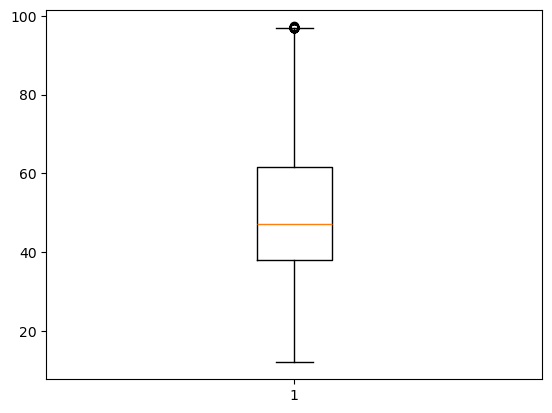

In [60]:
#Удалим выбросы
remove_outliers('total_area')

#### is_apartment

In [62]:
#Уникальные значения
df['is_apartment'].value_counts() 

is_apartment
False    2197
True       14
Name: count, dtype: int64

In [63]:
# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df['is_apartment'].isna().sum()}')

Количество пропущенных значений: 17285


In [64]:
#Заменим пропуски на False (не апартамены, а квартира)
df['is_apartment'] = df['is_apartment'].astype(bool).fillna(False)

#### studio

In [66]:
# Просмотр уникальных значений
df['studio'].value_counts()

studio
False    19363
True       133
Name: count, dtype: int64

#### open_plan

In [68]:
# Просмотр уникальных значений
df['open_plan'].value_counts()

open_plan
False    19434
True        62
Name: count, dtype: int64

#### balcony

In [70]:
# Просмотр уникальных значений
df['balcony'].value_counts()

balcony
1.0    3639
2.0    3294
0.0    3073
5.0     221
4.0     121
3.0      54
Name: count, dtype: int64

In [71]:
#Проверяем кол-во пропусков
print(f'Кол-во пропусков в balcony: {df['balcony'].isna().sum()}')

Кол-во пропусков в balcony: 9094


In [72]:
# Заменим отсутствующие значения в столбце balcony на 0
df['balcony'] = df['balcony'].fillna(0)

In [73]:
# Поменяем тип данных на int
df['balcony'] = df['balcony'].astype(int)

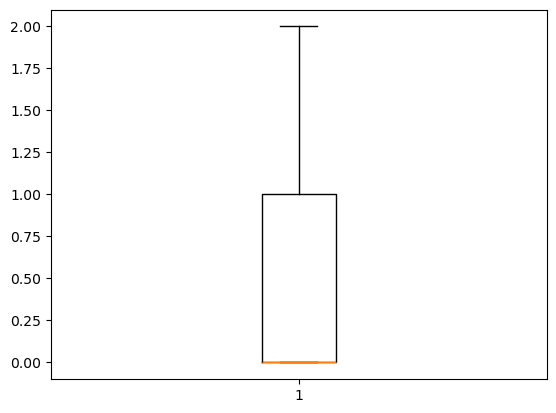

In [74]:
#Удалим выбросы
remove_outliers('balcony')

#### kitchen_area

In [76]:
# Просмотр значений
df['kitchen_area'].unique()

array([11.  ,  8.3 ,  9.1 , 14.4 , 18.9 ,  8.81,  6.5 ,  8.5 ,  6.  ,
        9.  ,  5.2 ,  8.  ,  7.6 ,  5.6 , 12.  ,  5.7 ,  6.1 , 19.6 ,
       15.  ,  7.  ,  9.2 ,   nan, 13.4 ,  6.3 , 11.6 ,  8.8 , 10.  ,
        9.5 , 15.5 , 10.7 , 11.1 , 20.  , 11.9 ,  5.3 , 11.5 ,  7.2 ,
        6.2 ,  7.5 , 10.4 ,  7.1 ,  4.9 ,  7.3 , 10.2 ,  6.4 ,  5.5 ,
        8.4 , 13.  , 23.6 , 10.8 ,  5.  ,  8.2 , 23.8 , 24.  ,  6.6 ,
       26.85, 17.  ,  7.8 ,  5.4 , 12.72, 19.  , 12.4 ,  7.9 , 10.3 ,
        9.8 , 17.5 , 20.91, 10.9 ,  9.7 ,  7.7 , 16.  ,  8.6 , 11.24,
       15.7 , 13.29, 14.  , 12.9 , 12.7 , 16.5 ,  9.36, 10.5 , 12.5 ,
        8.7 , 21.4 , 11.52,  8.9 , 14.2 ,  8.1 , 10.44,  4.5 , 18.4 ,
        7.4 , 11.3 , 13.1 , 10.19,  7.06, 10.6 , 11.2 ,  9.6 , 11.4 ,
       11.7 , 25.  ,  5.1 ,  9.9 , 14.3 , 18.  , 11.8 , 13.3 , 17.7 ,
       23.1 , 11.33, 13.5 , 17.2 , 13.8 , 12.3 , 50.  ,  9.3 ,  5.8 ,
       15.4 , 12.2 , 12.88,  9.28, 16.1 , 14.5 ,  5.9 , 10.1 , 15.1 ,
        8.98, 10.59,

In [77]:
# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df['kitchen_area'].isna().sum()}')

Количество пропущенных значений: 1892


Определим значение для замены пропусков: рассчитаем для каждой строки разницу между total_area и living_area, а затем рассчитаем какой процент от нежилой зоны в среднем занимает кухня

In [79]:
# доля, которую в среднем занимает кухня от нежилой территории
median_kitchen_percentage = round((df['kitchen_area'] / (df['total_area'] - df['living_area'])).median(), 1)
print(f'Доля кухни от нежилой зоны в среднем равна {median_kitchen_percentage}')

Доля кухни от нежилой зоны в среднем равна 0.4


In [80]:
#для каждой строки, где известы total_area и living_area, получим значение для kitchen_area
df.loc[df['kitchen_area'].isna(), 'kitchen_area'] = df['total_area'] - df['living_area'] * median_kitchen_percentage

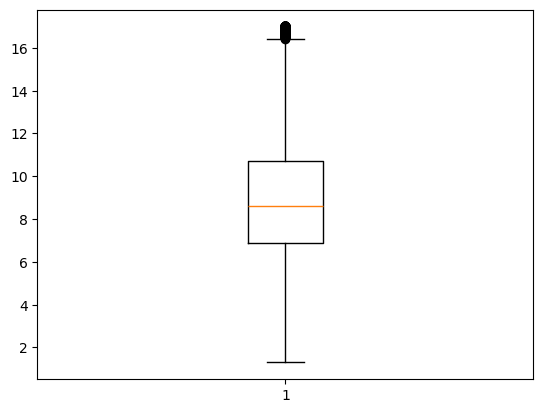

In [81]:
#Удалим выбросы
remove_outliers('kitchen_area')

#### airports_nearest

In [83]:
# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df['airports_nearest'].isna().sum()}')

Количество пропущенных значений: 4363


In [84]:
#Оставим незаполненными, так как нет возможности заполнить

#### cityCenters_nearest

In [86]:
# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df['cityCenters_nearest'].isna().sum()}')

Количество пропущенных значений: 4353


In [87]:
#Оставим незаполненными, так как нет возможности заполнить

#### days_exposition

In [89]:
# Просмотр уникальных значений
df['days_exposition'].unique()

array([  81.,  558.,   55., ..., 1007.,  971.,  808.])

In [90]:
df['days_exposition'].max()

1553.0000000000002

In [91]:
# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df['days_exposition'].isna().sum()}')

Количество пропущенных значений: 1995


In [92]:
#Замена пропусков
df['days_exposition'] = df['days_exposition'].fillna(0)

In [93]:
#Изменение типа данных
df['days_exposition'] = df['days_exposition'].astype('int')

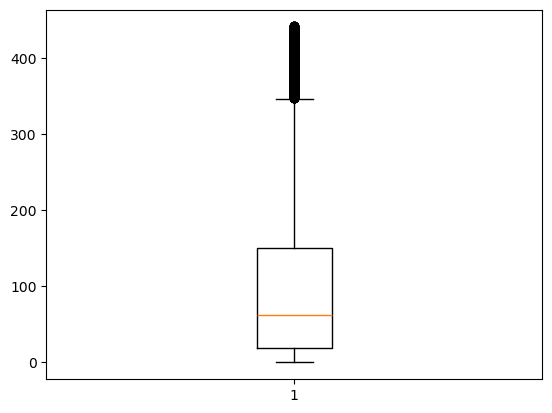

In [94]:
#Удалим выбросы
remove_outliers('days_exposition')

#### locality_name

In [96]:
# Просмотр уникальных значений
df['locality_name'].unique()

array(['посёлок Шушары', 'городской посёлок Янино-1', 'посёлок Парголово',
       'посёлок Мурино', 'Санкт-Петербург', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Колпино', 'Гатчина',
       'поселок Мурино', 'деревня Фёдоровское', 'Выборг', 'Кронштадт',
       'Кировск', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Всеволожск', 'Волхов',
       'Кингисепп', 'Приозерск', 'деревня Куттузи', 'Сестрорецк',
       'посёлок Аннино', 'деревня Заклинье', 'поселок Торковичи',
       'поселок Первомайское', 'Красное Село', 'посёлок Понтонный',
       'деревня Старая', 'Павловск', 'деревня Лесколово', 'Ивангород',
       'деревня Новое Девяткино', 'Сланцы', 'Шлиссельбург', 'Сясьстрой',
       'Никольское', 'Зеленогорск', 'поселок Новый Свет',
       'деревня Кальтино', 'Кудрово', 'поселок Р

In [97]:
print(f'Количество уникальных значений до замены: {len(df['locality_name'].unique())}')

Количество уникальных значений до замены: 332


In [98]:
#замена названий
names_variant = {'посёлок': 'поселок',
                 'посёлок городского типа': 'поселок',
                 'поселок городского типа': 'поселок',
                 'городской поселок': 'поселок',
                 'городской посёлок': 'поселок',
                 'поселок при железнодорожной станции': 'поселок',
                 'посёлок при железнодорожной станции': 'поселок',
                 'поселок станции': 'поселок',
                 'посёлок станции': 'поселок'}
df['locality_name'] = df['locality_name'].replace(names_variant, regex=True)

In [99]:
print(f'Количество уникальных значений после замены: {len(df['locality_name'].unique())}')

Количество уникальных значений после замены: 307


In [100]:
# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df['locality_name'].isna().sum()}')

Количество пропущенных значений: 20


#### parks_nearest и parks_around3000

In [102]:
df['parks_around3000'].value_counts()

parks_around3000
0.0    6953
1.0    3330
2.0     846
3.0     228
Name: count, dtype: int64

Проверим зависимость между столбцами "parks_around3000" - число парков в радиусе 3 км и "parks_nearest" - расстояние до ближайшего парка (м).

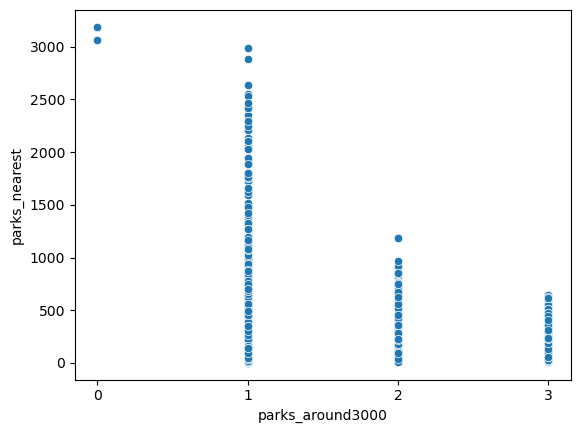

In [104]:
filtered_df = df[(df['parks_around3000'].notna()) & (df['parks_nearest'].notna())]
x = filtered_df['parks_around3000']
y = filtered_df['parks_nearest']

sns.scatterplot(data=filtered_df, x=x, y=y)

plt.xticks(range(int(filtered_df['parks_around3000'].min()), int(filtered_df['parks_around3000'].max()) + 1))
plt.show()

In [105]:
filtered_df = df[(df['parks_around3000'] > 0)]
print(f'Если значение в parks_around3000 > 0, то пропущенных в parks_nearest {len(filtered_df[(pd.isna(filtered_df['parks_nearest']))])}, максимальное значение равно {filtered_df['parks_nearest'].max()}') 

Если значение в parks_around3000 > 0, то пропущенных в parks_nearest 0, максимальное значение равно 2984.0


In [106]:
filtered_df = df[(df['parks_around3000'] == 0)]
print(f'Если значение в parks_around3000 == 0, то пропущенных в parks_nearest {len(filtered_df[(pd.isna(filtered_df['parks_nearest']))])}, максимальное значение равно {filtered_df['parks_nearest'].max()}') 

Если значение в parks_around3000 == 0, то пропущенных в parks_nearest 6950, максимальное значение равно 3190.0


In [107]:
filtered_df = df[(pd.isna(df['parks_around3000']))]
print(f'Если значение в parks_around3000 пропущено, то пропущенных в parks_nearest: {filtered_df['parks_nearest'].isna().sum()}, максимальное значение равно {filtered_df['parks_nearest'].max()}')

Если значение в parks_around3000 пропущено, то пропущенных в parks_nearest: 3961, максимальное значение равно nan


In [108]:
filtered_df = df[(pd.notna(df['parks_nearest']))]
print(f'Если значение в parks_nearest заполнено, то пропущенных в parks_around3000: {filtered_df['parks_around3000'].isna().sum()}, максимальное значение равно {filtered_df['parks_around3000'].max()}')

Если значение в parks_nearest заполнено, то пропущенных в parks_around3000: 0, максимальное значение равно 3.0


Исходя из результатов выше, можно разбить данные с пропусками в parks_nearest на две группы:

1 группа: известно, что в радиусе 3 км нет парка

2 группа: неизвестно, есть ли в радиусе 3 км парк, так как значение в parks_around3000 пропущено

Сделаем замену для первой группы в поле parks_nearest и укажем расстояние больше 3 км, например, 3100.
Для второй группы оставим пропуски.

In [110]:
#Известно, что в радиусе 3 км нет парка. Делаем замену:
filtered_df = df[(df['parks_around3000'] == 0)]
df.loc[(df['parks_nearest'].isna()) & (df['parks_around3000'] == 0), 'parks_nearest'] = 3100

In [111]:
#проверяем кол-во пропусков после замен
print(f'Кол-во пропусков в parks_around3000: {df['parks_around3000'].isna().sum()}')
print(f'Кол-во пропусков в parks_nearest: {df['parks_nearest'].isna().sum()}')

Кол-во пропусков в parks_around3000: 3961
Кол-во пропусков в parks_nearest: 3961


#### ponds_nearest и ponds_around3000

In [113]:
df['ponds_around3000'].value_counts()

ponds_around3000
0.0    6202
1.0    3557
2.0    1045
3.0     553
Name: count, dtype: int64

Все шаги выполним аналогично тому, что сделали для двух параметров выше:
Проверим зависимость между столбцами "ponds_around3000" - число водоемов в радиусе 3 км и "ponds_nearest" - расстояние до ближайшего водоема (м).

In [115]:
filtered_df = df[(df['ponds_around3000'] > 0)]
print(f'Если значение в ponds_around3000 > 0, то пропущенных в ponds_nearest {len(filtered_df[(pd.isna(filtered_df['ponds_nearest']))])}, максимальное значение равно {filtered_df['ponds_nearest'].max()}') 

Если значение в ponds_around3000 > 0, то пропущенных в ponds_nearest 0, максимальное значение равно 1344.0


In [116]:
filtered_df = df[(df['ponds_around3000'] == 0)]
print(f'Если значение в ponds_around3000 == 0, то пропущенных в ponds_nearest {len(filtered_df[(pd.isna(filtered_df['ponds_nearest']))])}, максимальное значение равно {filtered_df['ponds_nearest'].max()}') 

Если значение в ponds_around3000 == 0, то пропущенных в ponds_nearest 6202, максимальное значение равно nan


In [117]:
filtered_df = df[(pd.isna(df['ponds_around3000']))]
print(f'Если значение в ponds_around3000 пропущено, то пропущенных в ponds_nearest: {filtered_df['ponds_nearest'].isna().sum()}, максимальное значение равно {filtered_df['ponds_nearest'].max()}')

Если значение в ponds_around3000 пропущено, то пропущенных в ponds_nearest: 3961, максимальное значение равно nan


In [118]:
filtered_df = df[(pd.notna(df['ponds_nearest']))]
print(f'Если значение в parks_nearest заполнено, то пропущенных в ponds_around3000: {filtered_df['ponds_around3000'].isna().sum()}, максимальное значение равно {filtered_df['ponds_around3000'].max()}')

Если значение в parks_nearest заполнено, то пропущенных в ponds_around3000: 0, максимальное значение равно 3.0


Cделаем замены по аналогии со столбцами "parks_around3000" и "parks_nearest"

In [120]:
#1 Так как в ponds_nearest всегда NaN, когда ponds_around3000 = 0, заменим в этом случае пропуски фиксированным значением 3100
df.loc[(df['ponds_nearest'].isna()) & (df['ponds_around3000'] == 0), 'ponds_nearest'] = 3100

In [121]:
#проверяем кол-во пропусков после замен
print(f'Кол-во пропусков в ponds_around3000: {df['ponds_around3000'].isna().sum()}')
print(f'Кол-во пропусков в ponds_nearest: {df['ponds_nearest'].isna().sum()}')

Кол-во пропусков в ponds_around3000: 3961
Кол-во пропусков в ponds_nearest: 3961


### Результаты обработки

In [123]:
print(f'Количество строк до обработки = {len_df_start}, количество строк после обработки = {len(df)}')

Количество строк до обработки = 23699, количество строк после обработки = 15318


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15318 entries, 1 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          15318 non-null  int64         
 1   last_price            15318 non-null  float64       
 2   total_area            15318 non-null  float64       
 3   first_day_exposition  15318 non-null  datetime64[ns]
 4   rooms                 15318 non-null  int64         
 5   ceiling_height        15318 non-null  float64       
 6   floors_total          15318 non-null  int32         
 7   living_area           15037 non-null  float64       
 8   floor                 15318 non-null  int64         
 9   is_apartment          15318 non-null  bool          
 10  studio                15318 non-null  bool          
 11  open_plan             15318 non-null  bool          
 12  kitchen_area          15318 non-null  float64       
 13  balcony              

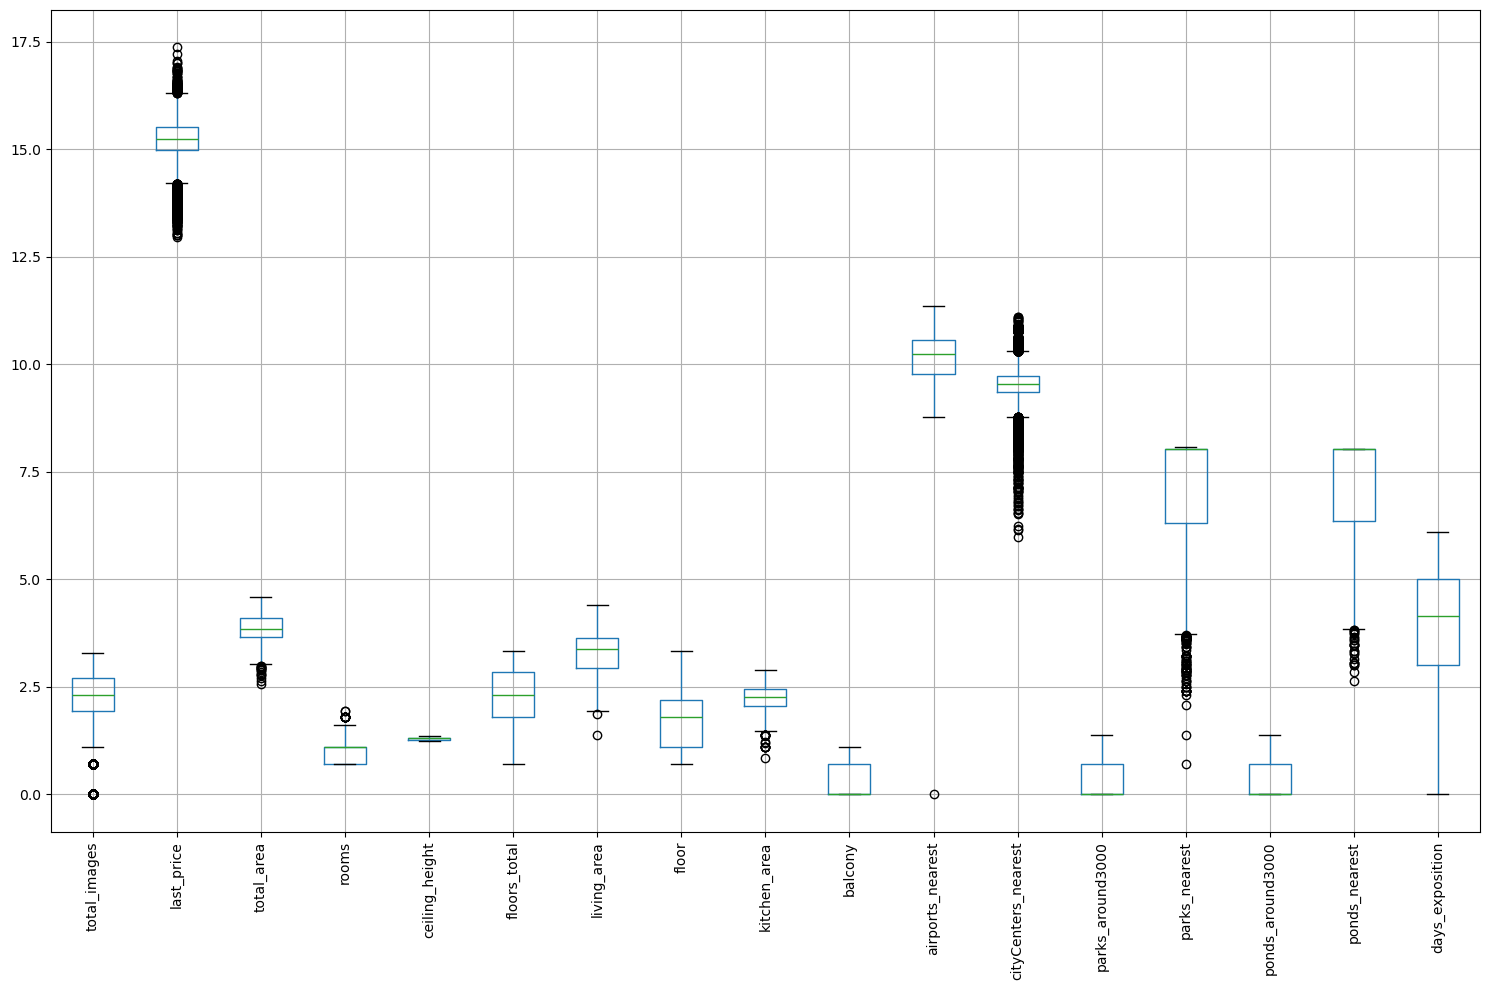

In [125]:
#выбросы
num_df = df.select_dtypes(include=['number'])
log_df = num_df.apply(lambda col: np.log(col + 1) if col.min() >= 0 else col)

plt.figure(figsize=(15, 10))
log_df.boxplot()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Этап 2. Добавление новых признаков

Добавим новые временные признаки (год, месяц, день недели публикации объявления), признак цена за квадратный метр, тип этажа квартиры (первый, последний, первый и последний, другой)

In [128]:
df['year'] = df['first_day_exposition'].dt.year
df['month'] = df['first_day_exposition'].dt.month
df['weekday'] = df['first_day_exposition'].dt.weekday
df['price_per_m2'] = (df['last_price'] / df['total_area']).round(2)
df['floor_type'] = df.apply(lambda row: 'Первый и последний' if row['floor'] == 1 and row['floors_total'] == 1 else ('Первый' if row['floor'] == 1 else ('Последний' if row['floor'] == row['floors_total'] else 'Другой')),axis=1)

In [129]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,year,month,weekday,price_per_m2,floor_type
1,7,3350000.0,40.40,2018-12-04,1,2.7,11,18.60,1,True,False,False,11.00,2,поселок Шушары,12817.0,18603.0,0.0,3100.0,0.0,3100.0,81,2018,12,1,82920.79,Первый
5,10,2890000.0,30.40,2018-09-10,1,2.7,12,14.40,5,True,False,False,9.10,0,городской поселок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55,2018,9,0,95065.79,Другой
6,6,3700000.0,37.30,2017-11-02,1,2.7,26,10.60,6,True,False,False,14.40,1,поселок Парголово,52996.0,19143.0,0.0,3100.0,0.0,3100.0,155,2017,11,3,99195.71,Другой
8,20,2900000.0,33.16,2018-05-23,1,2.7,27,15.43,26,True,False,False,8.81,0,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189,2018,5,2,87454.76,Другой
9,18,5400000.0,61.00,2017-02-26,3,2.5,9,43.60,7,True,False,False,6.50,2,Санкт-Петербург,50898.0,15008.0,0.0,3100.0,0.0,3100.0,289,2017,2,6,88524.59,Другой


Сделаем проверку новых признаков year и price_per_m2

In [131]:
df['year'].value_counts()

year
2018    5929
2017    5537
2019    2087
2016    1471
2015     289
2014       5
Name: count, dtype: int64

In [132]:
#уберем данные за 2015 и 2014 год, как уже устаревшие
df = df.query("year != 2014 and year != 2015")

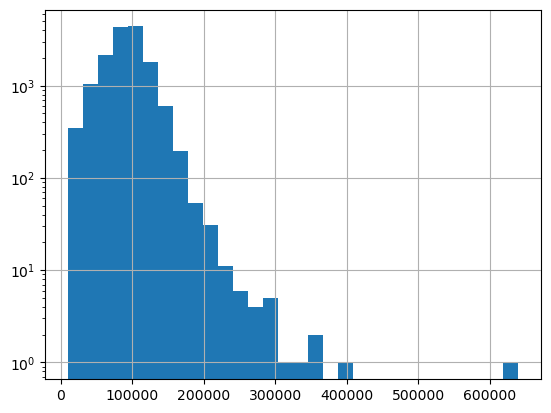

In [133]:
df.price_per_m2.hist(bins=30, log=True);

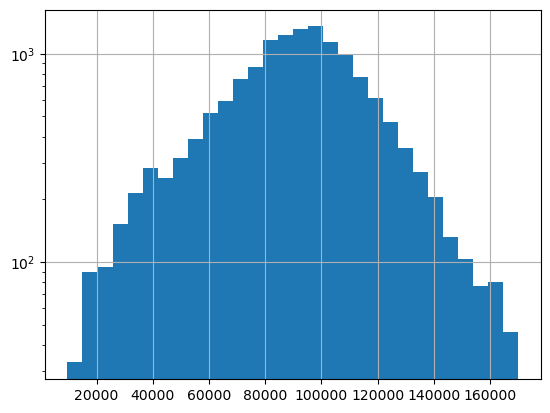

In [134]:
#Уберем 1% аномальных значений. Воспользуемся 99% персентилем, чтобы убрать аномально высокие значения
threshold = df['price_per_m2'].quantile(0.99)
df = df[df.price_per_m2 <= threshold]

# Визуализируем
df['price_per_m2'].hist(bins=30, log=True)
plt.show()

In [135]:
df.describe()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,year,month,weekday,price_per_m2
count,14873.000000,1.487300e+04,14873.000000,14873,14873.000000,14873.000000,14873.000000,14598.000000,14873.000000,14873.000000,14873.000000,10973.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,14873.000000,14873.000000,14873.000000,14873.000000,14873.000000
mean,9.907080,4.510971e+06,50.150510,2018-01-22 08:27:20.126403328,1.856048,2.644597,10.966449,28.714729,5.991596,8.948487,0.569825,29307.936207,15809.518121,0.493171,2100.448552,0.632307,1952.006192,97.565992,2017.573791,6.365763,2.579910,90504.996941
min,0.000000,4.300000e+05,14.000000,2016-01-05 00:00:00,1.000000,2.450000,1.000000,3.000000,1.000000,1.300000,0.000000,6450.000000,399.000000,0.000000,1.000000,0.000000,13.000000,0.000000,2016.000000,1.000000,0.000000,9615.380000
25%,6.000000,3.200000e+06,38.000000,2017-08-03 00:00:00,1.000000,2.550000,5.000000,18.000000,2.000000,6.800000,0.000000,17430.000000,11567.750000,0.000000,555.250000,0.000000,582.000000,19.000000,2017.000000,3.000000,1.000000,74025.970000
50%,10.000000,4.200000e+06,46.100000,2018-02-01 00:00:00,2.000000,2.700000,9.000000,28.100000,5.000000,8.500000,0.000000,28168.000000,14137.000000,0.000000,3100.000000,0.000000,3100.000000,60.000000,2018.000000,6.000000,3.000000,91860.470000
75%,14.000000,5.450000e+06,60.000000,2018-09-25 00:00:00,2.000000,2.700000,16.000000,36.900000,8.000000,10.690000,1.000000,39221.000000,16892.000000,1.000000,3100.000000,1.000000,3100.000000,143.000000,2018.000000,10.000000,4.000000,107843.140000
max,26.000000,1.621800e+07,97.300000,2019-05-03 00:00:00,6.000000,2.850000,27.000000,80.000000,27.000000,17.000000,2.000000,84853.000000,65952.000000,3.000000,3190.000000,3.000000,3100.000000,441.000000,2019.000000,12.000000,6.000000,170103.090000
std,5.448495,1.994467e+06,15.406593,NaN,0.834584,0.091965,6.484455,11.363599,4.858404,2.713822,0.779725,13398.132947,8191.550298,0.712654,1283.202333,0.830024,1283.241720,103.387229,0.847157,3.448833,1.794275,27850.877859


In [136]:
#сохраним обработтаные данные в новый датасет
df.to_csv('real_estate_processed.csv', index=False)